# Compile **PP-OCR** into **TVM** from **ONNX** using **`Relay`**

# Detection Model

Differentiable Binarization

## Reference

Author: Yunho Cho

This notebook is based on ["How to Compile Models from ONNX"](https://tvm.apache.org/docs/how_to/compile_models/from_onnx.html#sphx-glr-how-to-compile-models-from-onnx-py) by Joshua Z. Zhang.

## Setup

### Platform

#### Python Command

In [1]:
def in_colab():
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

if in_colab():
    print("This code is running in Google Colab")
else:
    print("This code is not running in Google Colab")

This code is not running in Google Colab


In [2]:
import platform

system = platform.system()
if system == "Darwin" or "Windows":
    pycmd = 'python3'
else: # linux
    pycmd = 'python'

### Install

In [3]:
# install nightly build of TVM Unity from MLC-AI
!{pycmd} -m pip install mlc-ai-nightly -f https://mlc.ai/wheels -q # --upgrade

In [4]:
# install onnx
!{pycmd} -m pip install onnx onnxoptimizer onnxruntime -q

In [5]:
# install netron
!{pycmd} -m pip install netron -q

### Filesystem

In [6]:
if 'cloned' not in globals():
    !git clone https://github.com/k2m5t2/tvm-ocr.git
    %cd "tvm-ocr"
cloned = True

fatal: destination path 'tvm-ocr' already exists and is not an empty directory.
/Users/yunhocho/Library/CloudStorage/GoogleDrive-yhjc2692@gmail.com/My Drive/Colab Notebooks/TVM/OCR/tvm-ocr


### Import

In [7]:
# basics
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
# onnx
import onnx
import onnxruntime as ort
# tvm
import tvm
from tvm import te
from tvm.contrib.download import download_testdata
# relay
import tvm.relay as relay
# relax
import tvm.relax as relax
from tvm.relax.testing import relay_translator, nn
import tvm.relax.frontend.onnx

In [8]:
# import netron
# import portpicker
# from google.colab import output

# port = portpicker.pick_unused_port()

### Helper

In [9]:
# TODO make this work in non-Colab environments
# def start_netron(model):
#   with output.temporary(): netron.start(model, port, browse=False)
#   output.serve_kernel_port_as_iframe(port, height='800')

## Model Diagnostics

[ONNXRuntime Docs: Model Usability Checker](https://onnxruntime.ai/docs/tutorials/mobile/helpers/model-usability-checker.html)

This is primarily meant for NNAPI/CoreML deployment options and less relevant for TVM. Regardless, it gives an additional point of view for analyzing the model.

In [10]:
!{pycmd} -m onnxruntime.tools.check_onnx_model_mobile_usability './models/onnx/ch_PP-OCRv4_det_infer.onnx'

INFO:  Checking models/onnx/ch_PP-OCRv4_det_infer.onnx for usability with ORT Mobile.
INFO:  Checking NNAPI
INFO:  Model should perform well with NNAPI as is: NO
INFO:  Checking if model will perform better if the dynamic shapes are fixed...
INFO:  Model should perform well with NNAPI if modified to have fixed input shapes: NO
INFO:  Checking CoreML
INFO:  Model should perform well with CoreML as is: NO
INFO:  Checking if model will perform better if the dynamic shapes are fixed...
INFO:  Model should perform well with CoreML if modified to have fixed input shapes: NO
INFO:  Re-run with log level of DEBUG for more details on the NNAPI/CoreML issues.
INFO:  ---------------
INFO:  Checking if pre-built ORT Mobile package can be used with models/onnx/ch_PP-OCRv4_det_infer.onnx once model is converted from ONNX to ORT format using onnxruntime.tools.convert_onnx_models_to_ort...
INFO:  Unsupported operators:
INFO:    ai.onnx:12:BatchNormalization
INFO:  
Model is not supported by the pre-bu

### Fix Input Shapes

[ONNXRuntime Docs: Making dynamic input shapes fixed](https://onnxruntime.ai/docs/tutorials/mobile/helpers/make-dynamic-shape-fixed.html)

Omitted `--dim_param p2o.DynamicDimension.3 --dim_value 1` from scope, because it seems necessary for variable-length text detection task.

In [11]:
!{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
--dim_param p2o.DynamicDimension.0 --dim_value 1 \
'./models/onnx/ch_PP-OCRv4_det_infer.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

In [12]:
!{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
--dim_param p2o.DynamicDimension.1 --dim_value 224 \
'./models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

In [13]:
!{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
--dim_param p2o.DynamicDimension.2 --dim_value 224 \
'./models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

In [14]:
# !{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
# --dim_param p2o.DynamicDimension.3 --dim_value 10 \
# './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

In [15]:
!{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
--dim_param p2o.DynamicDimension.4 --dim_value 224 \
'./models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

In [16]:
!{pycmd} -m onnxruntime.tools.make_dynamic_shape_fixed \
--dim_param p2o.DynamicDimension.5 --dim_value 224 \
'./models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx' './models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx'

## Load ONNX model

In [17]:
model_path = "./models/onnx/ch_PP-OCRv4_det_infer.onnx"
# model_path = "./models/onnx/ch_PP-OCRv4_det_infer_fixed_attempt1.onnx"
onnx_model = onnx.load(model_path)

### Inspect

In [18]:
# onnx_model.graph

In [19]:
print("Input:", onnx_model.graph.input)
print("Output:", onnx_model.graph.output)

Input: [name: "x"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "p2o.DynamicDimension.0"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_param: "p2o.DynamicDimension.1"
      }
      dim {
        dim_param: "p2o.DynamicDimension.2"
      }
    }
  }
}
]
Output: [name: "sigmoid_0.tmp_0"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "p2o.DynamicDimension.3"
      }
      dim {
        dim_value: 1
      }
      dim {
        dim_param: "p2o.DynamicDimension.4"
      }
      dim {
        dim_param: "p2o.DynamicDimension.5"
      }
    }
  }
}
]


In [20]:
# start_netron(model_path)

In [21]:
# Check for quantized nodes or tensors
quantized = False
for node in onnx_model.graph.node:
    for attr in node.attribute:
        if attr.name == 'value_type' and (attr.i == 2 or attr.i == 3):  # 2: INT8, 3: UINT8
            quantized = True
            break

if quantized:
    print("The model is quantized.")
else:
    print("The model is not quantized.")

The model is not quantized.


## Load a test image


In [22]:
size = 224

In [23]:
# just shape
# x = np.zeros(shape=[1, 3, size, size], dtype=np.int8)
# x = np.zeros(shape=[1, 3, size, size], dtype=np.float32)

In [24]:
# real image
img_path = "./test/test_images/price_tags.jpg"
# img_path = "./test_images/sparse_text_480p.jpg"
img = Image.open(img_path).resize((size, size))
x = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(np.float32)/256

## Compile

### ONNX

In [25]:
providers = ['CPUExecutionProvider']
onnx_ex = ort.InferenceSession("./models/onnx/ch_PP-OCRv4_det_infer.onnx", providers=providers)

In [26]:
x.shape

(1, 3, 224, 224)

In [27]:
target = "llvm"

input_name = "x"
shape_dict = {input_name: x.shape}

### With Relay

In [28]:
relay_mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    relay_ex = relay.build_module.create_executor(
        # "graph", relay_mod, tvm.cpu(0), target, params
        "vm", relay_mod, tvm.cpu(0), target, params
    ).evaluate()

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [29]:
# relay_mod

### With Relax

#### Translated from Relay

In [30]:
relax_t_mod = relay_translator.from_relay(relay_mod["main"], target)

with tvm.transform.PassContext(opt_level=1):
        relax_t_ex = relax.build(relax_t_mod, target)

relax_t_vm = relax.VirtualMachine(relax_t_ex, tvm.cpu())

In [31]:
# relax_t_mod

#### Using ONNX Frontend

In [32]:
# relax_o_mod, params = relax.frontend.onnx.from_onnx(onnx_model, shape_dict)

# with tvm.transform.PassContext(opt_level=1):
#         relax_o_ex = relax.build(relax_o_mod, target)

# relax_o_vm = relax.VirtualMachine(relax_o_ex, tvm.cpu())

`OpNotImplemented: The following operators are not supported for frontend ONNX: HardSigmoid, ConvTranspose`

In [33]:
# Is it available in Relax's `nn` API? Doesn't look like it.
dir(relax.frontend.nn)

['Any',
 'BlockBuilder',
 'Callable',
 'Conv1D',
 'ConvTranspose1D',
 'Dict',
 'Effect',
 'Embedding',
 'ExternModule',
 'GELU',
 'IOEffect',
 'IntExpr',
 'KVCache',
 'LayerNorm',
 'Linear',
 'List',
 'Module',
 'ModuleList',
 'MultiLinear',
 'Mutator',
 'Optional',
 'Parameter',
 'RMSNorm',
 'ReLU',
 'Sequence',
 'SiLU',
 'SourceModule',
 'SpecBuilder',
 'SubroutineMixin',
 'Tensor',
 'TensorStructInfo',
 'Tuple',
 'TupleStructInfo',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_tensor_op',
 'add',
 'astype',
 'broadcast_to',
 'chunk',
 'concat',
 'conv1d',
 'conv1d_transpose',
 'conv2d',
 'core',
 'divide',
 'full',
 'gelu',
 'get_default_dtype',
 'get_timestep_embedding',
 'group_norm',
 'interpolate',
 'layer_norm',
 'math',
 'matmul',
 'maximum',
 'minimum',
 'modules',
 'multiply',
 'np',
 'op',
 'pad',
 'permute_dims',
 'print_',
 'relu',
 'repeat',
 'reshape',
 'rms_norm',
 'rx',
 'sca

## Run Inference



In [34]:
dtype = "float32"

### Compare Inputs

In [35]:
print(tvm.nd.array(x.astype(dtype)))
print(x.astype(dtype))
np.allclose(tvm.nd.array(x.astype(dtype)).numpy(), x.astype(dtype))

[[[[0.2890625  0.2578125  0.23828125 ... 0.08203125 0.09765625
    0.04296875]
   [0.27734375 0.25390625 0.2265625  ... 0.08203125 0.09375
    0.0390625 ]
   [0.26953125 0.234375   0.22265625 ... 0.078125   0.1015625
    0.04296875]
   ...
   [0.47265625 0.44140625 0.41796875 ... 0.59765625 0.609375
    0.6015625 ]
   [0.4296875  0.390625   0.37109375 ... 0.58984375 0.59765625
    0.5859375 ]
   [0.37890625 0.328125   0.328125   ... 0.58203125 0.59765625
    0.59375   ]]

  [[0.48046875 0.51953125 0.53125    ... 0.03125    0.0546875
    0.01171875]
   [0.47265625 0.50390625 0.51953125 ... 0.03125    0.0546875
    0.015625  ]
   [0.45703125 0.48828125 0.5078125  ... 0.03125    0.05078125
    0.01953125]
   ...
   [0.46875    0.5078125  0.55078125 ... 0.1640625  0.33984375
    0.20703125]
   [0.4609375  0.50390625 0.52734375 ... 0.0546875  0.109375
    0.0546875 ]
   [0.4609375  0.47265625 0.50390625 ... 0.01171875 0.00390625
    0.01171875]]

  [[0.5859375  0.5390625  0.45703125 ... 0.0

True

### ONNX

In [36]:
onnx_pred = onnx_ex.run(["sigmoid_0.tmp_0"], {"x": x})

### Relay

In [37]:
relay_output = relay_ex(tvm.nd.array(x.astype(dtype))).numpy()

### Relax (Translated)

In [38]:
relax_t_output = relax_t_vm["main"](tvm.nd.array(x.astype(dtype))).numpy()
# relax_t_output = relax_t_vm["main"](tvm.nd.array(x.astype(dtype)), *params).numpy()

### Relax (ONNX)

In [39]:
# relax_o_output = relay_ex(tvm.nd.array(x.astype(dtype))).numpy()

## Compare results

In [40]:
onnx_pred

[array([[[[-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          ...,
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08]]]],
       dtype=float32)]

In [41]:
relay_output

array([[[[1.07113103e-13, 1.06383184e-13, 3.30329080e-12, ...,
          4.41769932e-14, 5.13602832e-15, 1.48915616e-13],
         [3.43007495e-15, 4.13973335e-15, 1.07437887e-12, ...,
          1.15952924e-15, 3.75500095e-17, 9.38406626e-16],
         [2.68813780e-13, 2.67289202e-13, 2.50271245e-12, ...,
          1.16786150e-15, 9.98165987e-14, 7.06513840e-13],
         ...,
         [4.78788219e-14, 6.48514640e-15, 3.82421950e-15, ...,
          1.86613767e-15, 1.46067486e-15, 4.95268465e-15],
         [4.28221044e-12, 2.25943342e-13, 8.70487967e-14, ...,
          6.02550019e-13, 1.37448169e-12, 9.67155392e-13],
         [6.90715410e-12, 4.00058784e-13, 2.90315020e-14, ...,
          6.28256995e-13, 4.93761716e-13, 7.41840834e-13]]]],
      dtype=float32)

In [42]:
relax_t_output

array([[[[1.07113306e-13, 1.06382974e-13, 3.30328451e-12, ...,
          4.41771626e-14, 5.13604780e-15, 1.48915616e-13],
         [3.43007495e-15, 4.13974944e-15, 1.07437258e-12, ...,
          1.15953368e-15, 3.75501518e-17, 9.38406626e-16],
         [2.68814295e-13, 2.67287169e-13, 2.50270312e-12, ...,
          1.16786595e-15, 9.98167816e-14, 7.06513840e-13],
         ...,
         [4.78789134e-14, 6.48512184e-15, 3.82423390e-15, ...,
          1.86613767e-15, 1.46069169e-15, 4.95270371e-15],
         [4.28221044e-12, 2.25942922e-13, 8.70487967e-14, ...,
          6.02553489e-13, 1.37448961e-12, 9.67160922e-13],
         [6.90715410e-12, 4.00058784e-13, 2.90315020e-14, ...,
          6.28258188e-13, 4.93761716e-13, 7.41843652e-13]]]],
      dtype=float32)

### Qualitatively

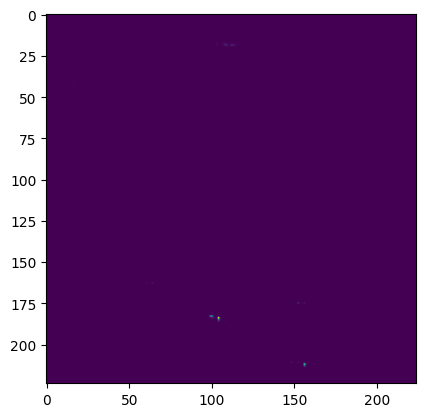

In [43]:
plt.imshow(onnx_pred[0][0, 0, ...])

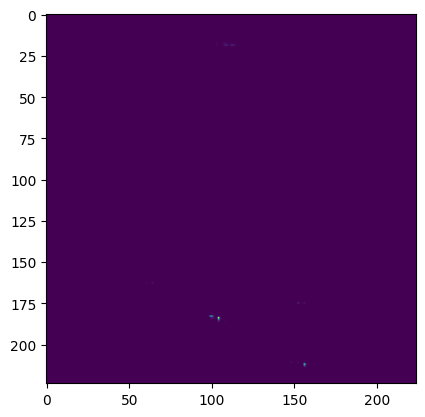

In [44]:
plt.imshow(relay_output[0, 0, ...])

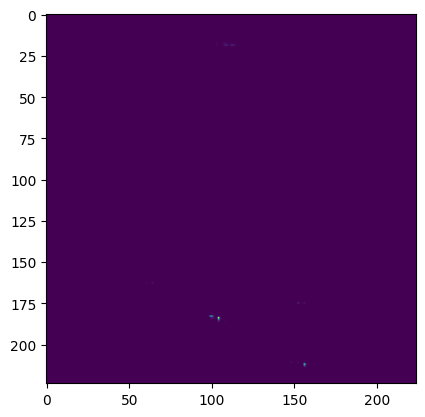

In [45]:
plt.imshow(relax_t_output[0, 0, ...])

### Another test...

In [46]:
test_img = Image.open("./test/test_images/sparse_text.jpg").resize((size, size))
x2 = np.array(test_img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256

In [47]:
# x2
x2.shape

(1, 3, 224, 224)

Check that inputs match, just in case

In [48]:
np.allclose(x2, x2.astype(dtype)/256)

False

In [49]:
# onnx
onnx_pred = onnx_ex.run(["sigmoid_0.tmp_0"], {"x": x2})

In [50]:
# tvm
relay_output = relay_ex(tvm.nd.array(x2)).numpy()
relax_t_output = relax_t_vm["main"](tvm.nd.array(x2.astype(dtype))).numpy()

In [51]:
onnx_pred[0].shape

(1, 1, 224, 224)

In [52]:
relay_output.shape

(1, 1, 224, 224)

In [53]:
onnx_pred

[array([[[[-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          ...,
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
          [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, ...,
           -5.9604645e-08, -5.9604645e-08, -5.9604645e-08]]]],
       dtype=float32)]

In [54]:
np.max(onnx_pred)

1.0

In [55]:
relay_output

array([[[[1.3299263e-12, 5.8066936e-13, 5.9893383e-13, ...,
          6.5194046e-14, 4.5928197e-15, 7.9680362e-14],
         [5.5653453e-14, 2.8799974e-14, 6.1331223e-14, ...,
          4.9112194e-15, 8.6432552e-17, 1.2973287e-15],
         [4.5508204e-13, 1.1603290e-13, 5.5000167e-13, ...,
          1.0939162e-14, 1.6390314e-13, 8.4873878e-13],
         ...,
         [4.3844890e-15, 5.7821937e-16, 1.8340119e-16, ...,
          1.0028651e-15, 3.5368501e-16, 3.5085513e-15],
         [7.1692977e-13, 3.4347379e-14, 2.5042714e-14, ...,
          2.7096127e-14, 4.4167496e-13, 9.5361490e-13],
         [1.0250738e-12, 4.9380669e-14, 6.4680253e-15, ...,
          2.7699517e-14, 8.9923606e-14, 4.6032611e-13]]]], dtype=float32)

In [56]:
np.max(relay_output)

1.0

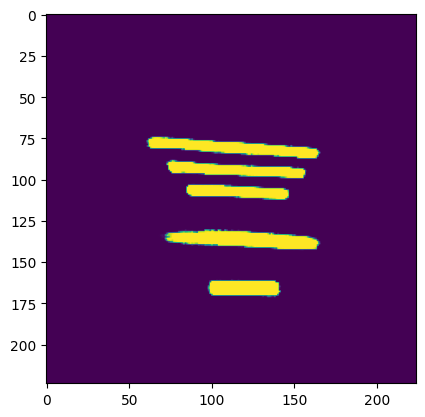

In [57]:
plt.imshow(onnx_pred[0][0, 0, ...])

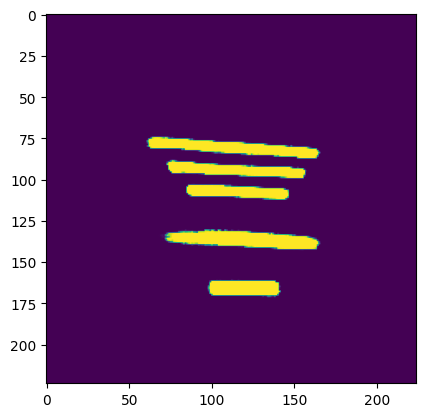

In [58]:
plt.imshow(relay_output[0, 0, ...])

In [59]:
def compare(fn):
    test_img = Image.open("./test_images/"+fn).resize((size, size))
    x2 = np.array(test_img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/25

    onnx_pred = onnx_ex.run(["sigmoid_0.tmp_0"], {"x": x2})
    tvm_output = relay_ex(tvm.nd.array(x2.astype(dtype)/256)).numpy()

    plt.imshow(onnx_pred[0][0, 0, ...]); plt.show()
    plt.imshow(tvm_output[0, 0, ...]); plt.show()

In [60]:
# compare("black.jpg")

## **Optimize**

### With Relay

### With Relax

In [61]:
from tvm.ir.module import IRModule
from tvm import runtime, transform
from tvm.target.target import Target
from tvm import meta_schedule as ms

from typing import Dict

In [62]:
def apply_opt_before_tuning(relay_mod: IRModule, params: Dict[str, runtime.NDArray], target: Target):
    with transform.PassContext(opt_level=3):
        main_func = relay_mod["main"]
        bind_main_func = relay.build_module.bind_params_by_name(main_func, params)
        relay_mod = IRModule.from_expr(bind_main_func)
        relay_mod = relay.transform.SimplifyInference()(relay_mod)
        relay_mod = relay.transform.FoldConstant()(relay_mod)
        relay_mod = relay.transform.FoldScaleAxis()(relay_mod)
        relay_mod = relay.transform.CanonicalizeOps()(relay_mod)
        relay_mod = relay.transform.AlterOpLayout()(relay_mod)
        relay_mod = relay.transform.FoldConstant()(relay_mod)

        relax_mod = relay_translator.from_relay(relay_mod["main"], target=target)
        relax_mod = relax.transform.AnnotateTIROpPattern()(relax_mod)
        relax_mod = relax.transform.FuseOps()(relax_mod)
        relax_mod = relax.transform.FuseTIR()(relax_mod)
    return relax_mod

In [63]:
def f_measurement(
    rt_mod: runtime.Module, device: runtime.ndarray.Device, input_data: Dict[str, runtime.NDArray]
):
    vm = relax.VirtualMachine(rt_mod, device=device)
    vm.save_function("main", "measure_func", **input_data, include_return=False)
    evaluator = vm.time_evaluator(
        func_name="measure_func",
        dev=device,
        # repeat=num_measurement_repeats,
        # number=num_measurements,
        min_repeat_ms=500,
    )
    return evaluator()

In [64]:
def get_runner():
    runner_config = {
        "evaluator_config": ms.runner.EvaluatorConfig(
            number=3,
            repeat=1,
            min_repeat_ms=100,
            enable_cpu_cache_flush=False,
        ),
        # "alloc_repeat": ARGS.alloc_repeat,
    }
    if rpc_config:
        runner = ms.runner.RPCRunner(
            rpc_config=rpc_config, max_workers=workers, **runner_config
        )
    else:
        runner = ms.runner.LocalRunner(**runner_config)

    return runner

In [65]:
target = 'llvm'
num_trials = 10
work_dir = './'
rpc_config = None
workers = None

In [66]:
relax_mod = apply_opt_before_tuning(relay_mod, params, target=target)
assert isinstance(relax_mod, tvm.IRModule)

In [67]:
# target = "llvm -num-cores=2"
target = "llvm -num-cores=10"
# target = tvm.target.Target("llvm")

In [68]:
# db = ms.relax_integration.tune_relax(
#     mod=relax_mod,
#     target=target,
#     params=params,
#     num_trials_per_iter=64,
#     max_trials_per_task=num_trials,
#     max_trials_global=num_trials,
#     # runner=get_runner(),
#     work_dir=work_dir,
# )
# executable = ms.relax_integration.compile_relax(
#     db,
#     mod=relax_mod,
#     target=target,
#     params=params,
# )

In [69]:
input_info = {input_name: x.shape}
input_data = {}

for input_name, input_shape in input_info.items():
    if dtype.startswith("float"):
        input_data[input_name] = np.random.uniform(size=input_shape).astype(dtype)
    else:
        input_data[input_name] = np.random.randint(
            low=0, high=10000, size=input_shape, dtype=dtype
        )

In [70]:
# dev = tvm.device(target.kind.name)
# result = f_measurement(executable.mod, dev, input_data)

### RPC

## **Test Performance**

In [71]:
import time
import cProfile
from functools import wraps
# def timeit(func):
#     @wraps(func)
#     def timeit_wrapper(*args, **kwargs):
#         start_time = time.perf_counter()
#         result = func(*args, **kwargs)
#         end_time = time.perf_counter()
#         total_time = end_time - start_time
#         print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
#         return result
#     return timeit_wrapper

def profileit(name):
    def inner(func):
        def wrapper(*args, **kwargs):
            prof = cProfile.Profile()
            retval = prof.runcall(func, *args, **kwargs)
            # Note use of name from outer scope
            prof.dump_stats(name)
            return retval
        return wrapper
    return inner

# Usage:
# @profileit("profile_for_func1_001")
# def func1(...)
#     ...

In [72]:
@profileit("pp-ocr_det_onnx.prof")
def measure_onnx(n=1000):
    for i in range(n):
        onnx_pred = onnx_ex.run(["sigmoid_0.tmp_0"], {"x": x2})

measure_onnx() # 0.008s / run

In [73]:
@profileit("pp-ocr_det_relay.prof")
def measure_relay(n=1000):
    for i in range(n):
        relay_output = relay_ex(tvm.nd.array(x2)).numpy()

measure_relay() # 0.011s / run

In [74]:
@profileit("pp-ocr_det_relax.prof")
def measure_relax(n=1000):
    for i in range(n):
        relax_t_output = relax_t_vm["main"](tvm.nd.array(x2.astype(dtype))).numpy()

measure_relax(n=10) # 0.35s / run

In [75]:
# tvm profiling
# ftimer = module.module.time_evaluator("run", dev, number=1, repeat=repeat)
# prof_res = np.array(ftimer().results) * 1000  # multiply 1000 for converting to millisecond
# print(
#     "%-20s %-19s (%s)" % (network, "%.2f ms" % np.mean(prof_res), "%.2f ms" % np.std(prof_res))
# )

## Deploy to C++

In [76]:
ex = relax.build(mod=relax_t_mod, target="llvm")

In [77]:
type(ex)

tvm.relax.vm_build.Executable

In [78]:
ex.export_library("./pp-ocr-det.so")

In [79]:
# find [where to start searching from]
#  [expression determines what to find] [-options] [what to find]
!find . -name pp-ocr-det.so

./pp-ocr-det.so


In [80]:
!exec ./pp-ocr-det.so

zsh:1: exec format error: ./pp-ocr-det.so


In [81]:
!pwd

/Users/yunhocho/Library/CloudStorage/GoogleDrive-yhjc2692@gmail.com/My Drive/Colab Notebooks/TVM/OCR/tvm-ocr


### LLVM Backend

### CUDA Backend

### Vulkan Backend

### OpenCL Backend

## **Test Deployment**

### @ Python

In [82]:
# const_params_dict = utils.load_params(artifact_path="dist", device=device)

In [83]:
dex = tvm.runtime.load_module("./pp-ocr-det.so")

In [84]:
device = tvm.cpu()

In [85]:
cpp_vm = relax.VirtualMachine(rt_mod=dex, device=device)

In [86]:
cpp_output = cpp_vm["main"](tvm.nd.array(x2.astype(dtype))).numpy()

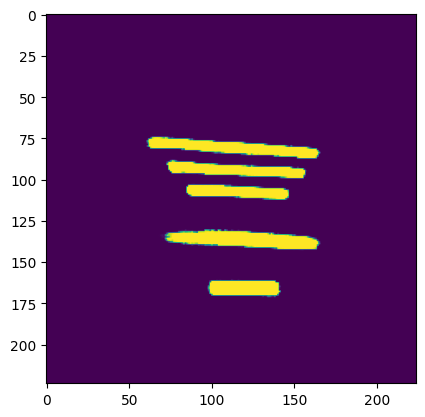

In [87]:
plt.imshow(cpp_output[0, 0, ...])

In [88]:
@profileit("pp-ocr_det_cpp.prof")
def measure_cpp(n=1000):
    for i in range(n):
        cpp_output = cpp_vm["main"](tvm.nd.array(x2.astype(dtype))).numpy()

measure_cpp(n=100) # ~ 0.35 sec / iteration @ M1

# Recognition Model

?

# Experiment

In [89]:
import tempfile

In [90]:
def relax_build_and_run(mod, target, dev, data, params={}):
    if params:
        mod = relax.transform.BindParams("main", params)(mod)
    with tempfile.TemporaryDirectory() as work_dir:
        db = ms.relax_integration.tune_relax(
            mod=mod,
            target=target,
            params=params,
            # task_scheduler="round-robin",
            num_trials_per_iter=32,
            max_trials_per_task=32,
            max_trials_global=1024,
            work_dir=work_dir,
        )
        ex = ms.relax_integration.compile_relax(
            db,
            mod=mod,
            target=target,
            params=params,
        )
    vm = relax.VirtualMachine(ex, dev)
    res = vm["main"](data)
    out = res.numpy()
    return ex, vm, out

In [91]:
relax_build_and_run(relax_t_mod, target, device, tvm.nd.array(x2.astype(dtype))) # params=None

2023-11-07 08:08:25 [INFO] Logging directory: /var/folders/pd/9mrlsj5x3q1c81q4jsd0gq7c0000gn/T/tmpu3yfrprn/logs


In [ ]:
relax_build_and_run(relax_mod, target, device, tvm.nd.array(x2.astype(dtype))) # params=None

# Unused

## Troubleshoot: Model Accuracy

In [ ]:
# import onnx
# from onnx import helper

# def split_onnx_model(model_path, split_point):
#     # Load the ONNX model
#     model = onnx.load(model_path)

#     # Create lists to hold nodes, initializers, and value_info for each subgraph
#     subgraph1_nodes = []
#     subgraph2_nodes = []
#     subgraph1_initializers = []
#     subgraph2_initializers = []
#     subgraph1_value_info = []
#     subgraph2_value_info = []

#     # Flag to determine which subgraph we're currently populating
#     split_reached = False

#     # Populate nodes for each subgraph
#     for node in model.graph.node:
#         if node.name == split_point:
#             split_reached = True
#         if not split_reached:
#             subgraph1_nodes.append(node)
#         else:
#             subgraph2_nodes.append(node)

#     # Populate initializers for each subgraph
#     for init in model.graph.initializer:
#         # If an initializer is used in subgraph1, add it to subgraph1_initializers
#         if any(node for node in subgraph1_nodes if init.name in [i.name for i in node.input]):
#             subgraph1_initializers.append(init)
#         # If an initializer is used in subgraph2, add it to subgraph2_initializers
#         if any(node for node in subgraph2_nodes if init.name in [i.name for i in node.input]):
#             subgraph2_initializers.append(init)

#     # Populate value_info for each subgraph
#     for vi in model.graph.value_info:
#         # If a tensor is produced in subgraph1 and consumed in subgraph2, add its details to both
#         if any(node for node in subgraph1_nodes if vi.name in [o.name for o in node.output]) and \
#            any(node for node in subgraph2_nodes if vi.name in [i.name for i in node.input]):
#             subgraph1_value_info.append(vi)
#             subgraph2_value_info.append(vi)

#     # Create new graphs for the subgraphs
#     subgraph1 = helper.make_graph(
#         nodes=subgraph1_nodes,
#         name="subgraph1",
#         inputs=model.graph.input,
#         outputs=[split_point],
#         initializer=subgraph1_initializers,
#         value_info=subgraph1_value_info
#     )
#     subgraph2 = helper.make_graph(
#         nodes=subgraph2_nodes,
#         name="subgraph2",
#         inputs=[split_point],
#         outputs=model.graph.output,
#         initializer=subgraph2_initializers,
#         value_info=subgraph2_value_info
#     )

#     # Save the subgraphs as separate ONNX models
#     onnx.save(helper.make_model(subgraph1), "subgraph1.onnx")
#     onnx.save(helper.make_model(subgraph2), "subgraph2.onnx")

# # Example usage
# # split_onnx_model("path_to_model.onnx", "node_name_to_split_at")


## Notes

By default, ONNX defines models in terms of dynamic shapes. The ONNX importer
retains that dynamism upon import, and the compiler attempts to convert the model
into a static shapes at compile time. If this fails, there may still be dynamic
operations in the model. Not all TVM kernels currently support dynamic shapes,
please file an issue on discuss.tvm.apache.org if you hit an error with dynamic kernels.

This particular model was build using an older version of ONNX. During the import
phase ONNX importer will run the ONNX verifier, which may throw a `Mismatched attribute type`
warning. Because TVM supports a number of different ONNX versions, the Relay model
will still be valid.